# CS4447 Final Project - Predicting Real Disasters from Tweets
## Hafez Gharbiah, Tyler Christeson
## data: https://www.kaggle.com/vbmokin/nlp-with-disaster-tweets-cleaning-data

## Rubric + Guidelines
1. Proper tagging of Github repository for final report as per deadlines (0.5 = 0.25 + 0.25 points)
1. Dataset and motivation slide (1 points)
    - How/why the dataset was collected and a description of the metadata of your dataset.
1. Actual task definition/research question (2 points)
    - What real-world problem are you trying to solve? What are the input and output of your analysis?
1. Literature review (2 points)
    - What other work has been done in this area, and how is your work novel compared to others?
1. Quality of cleaning (6 points, 2 points each) 
    - Data cleaning and type conversion activity. Please share anything unusual you faced during this activity.
    - What did you do about missing values and why? Handling missing values properly is very important.
    - New feature/attribute creation and data summary statistics and interpretation.
1. Visualization (8 points, 2 points each)
    - Data visualization activity (box plot, bar plot, violin plot, and pairplot to see relationships and distribution, etc.).
    - Describe anything you find in the data after each visualization.
    - What data visualization helped you understand about data distribution.
    - What you did about possible outlier as per data distribution visualization. (Did you confirm with your client whether it is actually an outlier or put a disclosure statement in your notebook if you decided to remove it?)

- The problem we're trying to solve is predicting whether a tweet is about a real disaster or not, which can be used to determine if emergency services need to be sent.

- We have a collection of 10,000 tweets. The attributes of the dataset are a unique identifier for each tweet, text of the tweet, where the tweet was sent from, keywords that could be used to identify disasters, and whether or not it is about a real disaster (only on some of them).

- Examples of records:
    - "Heard about # earthquake is different cities, stay safe everyone ." 
    - "Please like and share our new page for our Indoor Trampoline Park Aftershock opening this fall !" 
    - " nowplaying Alfons - Ablaze 2015 on Puls Radio pulsradio" 
    - "Coincidence Or # Curse ? Still # Unresolved Secrets From Past # accident"

- This is a noisy data set because the tweets are not all about disasters, and certain disaster keywords are used in contexts that are not disasters . For example, while "ablaze" is used in several real disaster tweets about ongoing fires, in the above example it is used as a song title. The same is true for many keywords, like "accident" and "aftershock" above.

- Feature engineering can be used in this dataset to:
    - extract years to see if we're tweeting about events that aren't current
    - extract news network name to determine if the accident is being reported on or not
    - topic modeling to extract relevant topics as features

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
import sklearn

from wordcloud import WordCloud
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/christesont/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
traindf = pd.read_csv('train_data_cleaning.csv',index_col=0)

traindf['original_tweet']=traindf.text
original_text = traindf.original_tweet
original_text = [nltk.word_tokenize(i) for i in original_text]
traindf['original_tweet_length'] = [len(w) for w in original_text]

7613

## Tweet Location

1.0

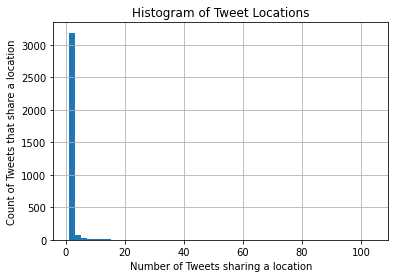

In [22]:
%matplotlib inline
fig, ax = plt.subplots()
ax= traindf.location.value_counts().hist(bins=50)
ax.set_title('Histogram of Tweet Locations')
ax.set_xlabel('Number of Tweets sharing a location')
ax.set_ylabel('Count of Tweets that share a location')

traindf.location.value_counts()[traindf.location.value_counts() == 1].sum()
traindf.location.value_counts().median()

In [3]:
# Quality of cleaning (6 points, 2 points each)
### Data cleaning and type conversion activity. Please share anything unusual you faced during this activity.
### What did you do about missing values and why? Handling missing values properly is very important.
### New feature/attribute creation and data summary statistics and interpretation. 
train_text = traindf.text
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('u')
stopwords.append('rt')
stopwords = set(stopwords + list(string.punctuation))
train_text = [nltk.word_tokenize(i) for i in train_text]

train_text = [[w.lower() for w in train_text[i] if w.lower() not in stopwords] for i in range(len(train_text))]

wnetl = WordNetLemmatizer()

def nltk_tag_pos(tag):   
    #adapted from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if tag[0]=='J':
        return wordnet.ADJ
    elif tag[0]=='V':
        return wordnet.VERB
    elif tag[0]=='N':
        return wordnet.NOUN
    elif tag[0]=='R':
        return wordnet.ADV
    else:          
        return wordnet.NOUN #noun is default lemmatize POS
    
train_text_POS = [nltk.pos_tag(i) for i in train_text]    
train_text = [[wnetl.lemmatize(i[0],nltk_tag_pos(i[1]))  if i[0] != 'us' else i[0] for i in j] for j in train_text_POS]
traindf['cleaned_tweet_length'] = [len(w) for w in train_text]
train_text = [' '.join(train_text[i]) for i in range(len(train_text))]

traindf.text = train_text
traindf['tweet_length_difference'] = traindf.original_tweet_length - traindf.cleaned_tweet_length

## Troubles with cleaning the text:
1. Lemmatizing internet slang, abbreviations, and punctuation resulted in interesting and sometimes incorrect results
    1. Specifically, lemmatizing the word 'us' or abbreviation 'US' led to the short 'u' which was incorrect and threw off analyses

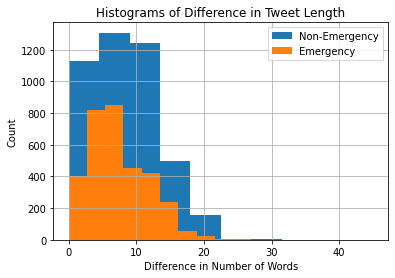

In [4]:
%matplotlib inline
fig, ax = plt.subplots()
ax= traindf[traindf.target==0].tweet_length_difference.hist()
ax = traindf[traindf.target==1].tweet_length_difference.hist()
ax.set_title('Histograms of Difference in Tweet Length')
ax.set_xlabel('Difference in Number of Words')
ax.set_ylabel('Count')
ax.legend(['Non-Emergency','Emergency'])


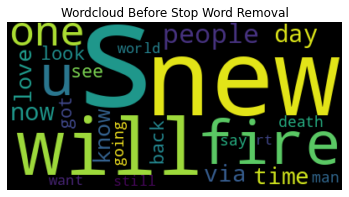

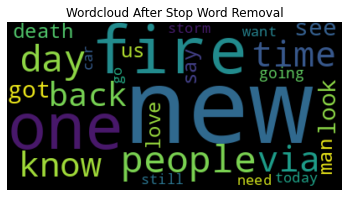

In [5]:
text = ' '.join(traindf.original_tweet.str.split(' ').sum()).lower()
# word cloud before stop word removal
wordcloud = WordCloud(max_words=25).generate(text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Before Stop Word Removal")
plt.show()

# word cloud after stop word removal
word_tokens = nltk.word_tokenize(text)

word_tokens = [word for word in word_tokens if word not in stopwords]
text = ' '.join(word_tokens)
wordcloud = WordCloud(max_words=25).generate(text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud After Stop Word Removal")
plt.show()


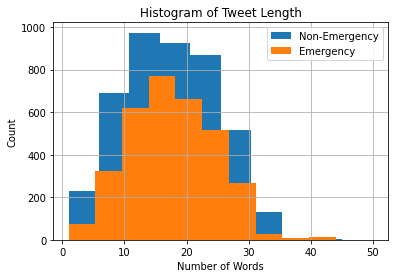

In [23]:
# g = sns.catplot(x="target",y="tweet_length",data=traindf)
%matplotlib inline

fig, ax = plt.subplots()
ax = traindf.original_tweet_length[traindf.target==0].hist()
ax = traindf.original_tweet_length[traindf.target==1].hist()
ax.set_title('Histogram of Tweet Length')
ax.set_xlabel('Number of Words')
ax.set_ylabel('Count')
ax.legend(['Non-Emergency','Emergency'])

## Bigrams before and after cleaning

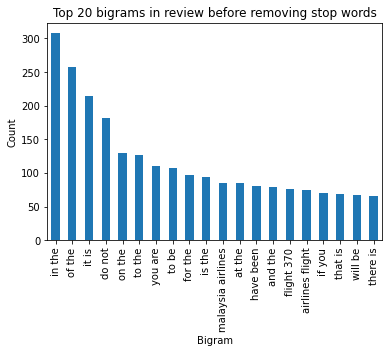

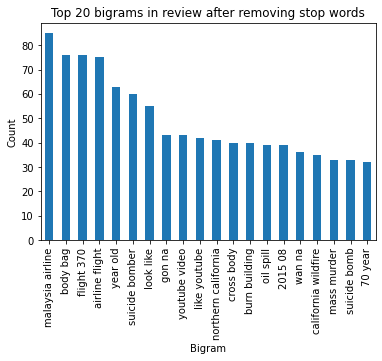

In [7]:
corpus = text
# source for bigram:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
def get_top_n_bigram(corpus, n=None,gram=2):
    vec = CountVectorizer(ngram_range=(gram, gram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(traindf['original_tweet'], 20)
gramdf = pd.DataFrame(common_words, columns = ['original_tweet' , 'count'])
fig, ax = plt.subplots()
ax = gramdf.groupby('original_tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Bigram', ylabel='Count', title='Top 20 bigrams in review before removing stop words')

common_words = get_top_n_bigram(traindf['text'], 20)
gramdf = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig, ax = plt.subplots()
ax =gramdf.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Bigram', ylabel='Count', title='Top 20 bigrams in review after removing stop words')

## Trigrams before and after cleaning

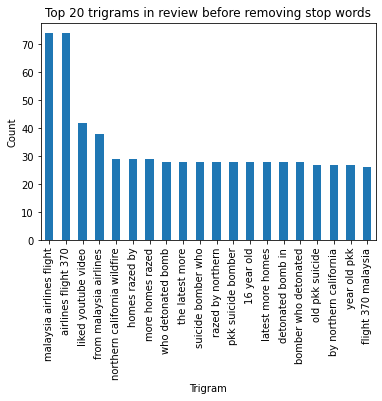

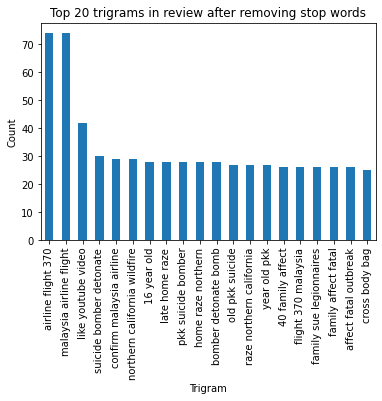

In [8]:
common_words = get_top_n_bigram(traindf['original_tweet'], 20,gram=3)
gramdf = pd.DataFrame(common_words, columns = ['original_tweet' , 'count'])
fig, ax = plt.subplots()
ax =gramdf.groupby('original_tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Trigram', ylabel='Count', title='Top 20 trigrams in review before removing stop words')

common_words = get_top_n_bigram(traindf['text'], 20,gram=3)
gramdf = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig, ax = plt.subplots()
ax = gramdf.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',xlabel='Trigram', ylabel='Count', title='Top 20 trigrams in review after removing stop words')

In [56]:
#bag of words model
cv = CountVectorizer(ngram_range=(1,3),max_features=50000)
x= cv.fit_transform(train_text).toarray()
y = traindf.target.values

#70:30 train-test split
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(x,y,test_size=0.3,random_state=1234)

import sklearn.naive_bayes


classifier = sklearn.naive_bayes.GaussianNB()
classifier.fit(xtrain,ytrain)

ypred = classifier.predict(xtest)
ypred

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
modeldf = pd.DataFrame()
models = ['Gaussian Naive Bayes']
precisions = [precision]
print(f'Model precision is: {precision}')

[[743 545]
 [228 768]]
Model precision is: 0.584920030464585


In [57]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(traindf.text, traindf.target, test_size=0.3, random_state=1234)

In [58]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=50000)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(xtrain, ytrain)
            
ypred = nb.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('Multinomial Naive Bayes')
precisions.append(precision)
print(f'Model precision is: {precision}')

[[1196   92]
 [ 351  645]]
Model precision is: 0.8751696065128901


In [59]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=50000)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(xtrain, ytrain)

ypred = sgd.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('SGD Classifier')
precisions.append(precision)
print(f'Model precision is: {precision}')

[[1266   22]
 [ 594  402]]
Model precision is: 0.9481132075471698


/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/stochastic_gradient.py:176: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  warnings.warn(
/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidan

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=50000)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(xtrain, ytrain)

ypred = logreg.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('Logistic Regression')
precisions.append(precision)
print(f'Model precision is: {precision}')

/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:431: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


[[1095  193]
 [ 284  712]]
Model precision is: 0.7867403314917127


/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


# Comparison of Model Precision

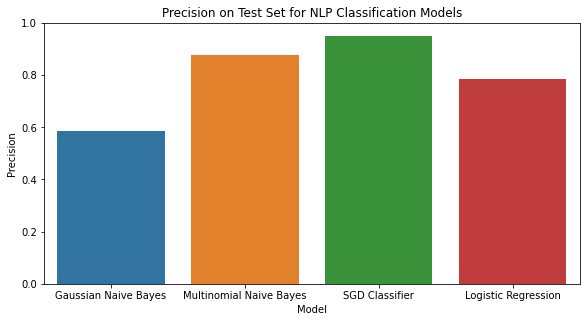

In [63]:
modeldf['model']=models
modeldf['precision']=precisions
modeldf
plt.figure(figsize=(9.6,4.8))
g= sns.barplot(x='model', y='precision',data=modeldf)
# g.set_xticklabels(rotation=30,labels=modeldf.model)
g.set(xlabel='Model', ylabel='Precision')
g.set_title('Precision on Test Set for NLP Classification Models')
g.set_ylim(0,1)
# for index, row in modeldf.iterrows():
#     g.text(row.model,row.precision, round(row.precision,2), color='black', ha="center")
plt.show()

In [64]:
# sgd.steps[2][1].intercept_
# sgd.steps[2][1].get_params()

print(len(sgd.steps[0][1].get_feature_names()))

# feature_coef = {}
# for i in range(len(sgd.steps[0][1].get_feature_names())):
#     feature_coef[sgd.steps[0][1].get_feature_names()[i]] = sgd.steps[2][1].coef_[0][i]
# feature_coef
dictionary = dict(zip(sgd.steps[0][1].get_feature_names(), sgd.steps[2][1].coef_[0]))
dictionary


50000


{'00': 0.40014028849696154,
 '00 11': 0.08476842134196232,
 '00 11 16': 0.04862691513105521,
 '00 11 utc': 0.04098715194241695,
 '00 18': 0.04054218174540926,
 '00 18 00': 0.04054218174540926,
 '00 25': -0.03710160400879063,
 '00 25 updated': -0.03710160400879063,
 '00 52': 0.001520920389970546,
 '00 52 25': 0.001520920389970546,
 '00 bestseller': -0.04627925272972589,
 '00 current': -0.031488505037066614,
 '00 current condition': -0.031488505037066614,
 '00 earthquake': 0.025494981344041788,
 '00 ep': 0.00031992086134168,
 '00 ep csismica': 0.025359273477713613,
 '00 ep sm': -0.025024060328144464,
 '00 epicenter': 0.02536357100615212,
 '00 epicenter sm': 0.02536357100615212,
 '00 hiroshima': 0.04054218174540926,
 '00 nnw': 0.04132038125898676,
 '00 nnw hana': 0.04132038125898676,
 '00 pm': 0.2347197423036048,
 '00 pm 00': 0.033645415986204005,
 '00 pm 06': 0.06408357277773535,
 '00 pm cdt': 0.050797302361877614,
 '00 pm edt': 0.029527867425715927,
 '00 pm rogue': 0.027482595272090668,

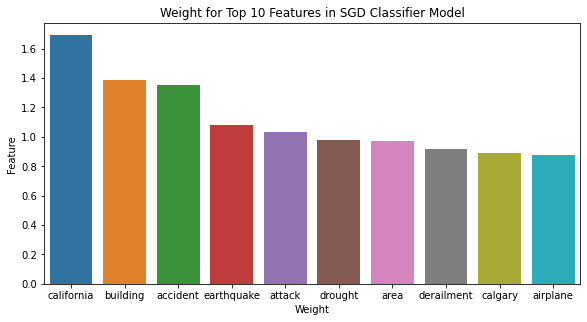

In [65]:
# max(feature_coef.values())
# # print(list(feature_coef.items())[list(feature_coef.values()).index(max(feature_coef.values()))])

# min(feature_coef.values())
# # print(list(feature_coef.items())[list(feature_coef.values()).index(min(feature_coef.values()))])
top_coef_df = pd.DataFrame()
feature = sorted(feature_coef, key=feature_coef.get, reverse=True)[:10]
weight = [feature_coef[i] for i in feature]
top_coef_df['feature']=feature
top_coef_df['weight']=weight

plt.figure(figsize=(9.6,4.8))
g= sns.barplot(x='feature', y='weight',data=top_coef_df)
g.set(xlabel='Weight', ylabel='Feature')
g.set_title('Weight for Top 10 Features in SGD Classifier Model')
plt.show()



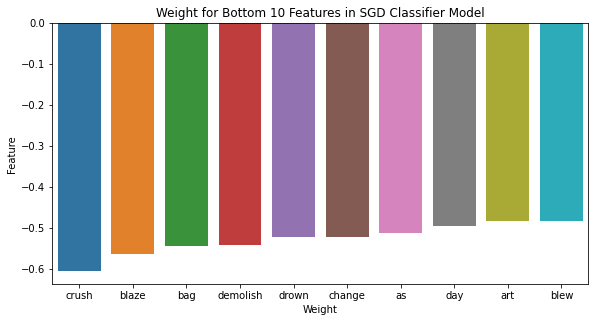

In [66]:
bottom_coef_df = pd.DataFrame()
feature2 = sorted(feature_coef, key=feature_coef.get, reverse=False)[:10]
weight2 = [feature_coef[i] for i in feature2]
bottom_coef_df['feature']=feature2
bottom_coef_df['weight']=weight2

plt.figure(figsize=(9.6,4.8))
g= sns.barplot(x='feature', y='weight',data=bottom_coef_df)
g.set(xlabel='Weight', ylabel='Feature')
g.set_title('Weight for Bottom 10 Features in SGD Classifier Model')
plt.show()